In [2]:
pwd

'/home/sdowell/scratch/Thesis'

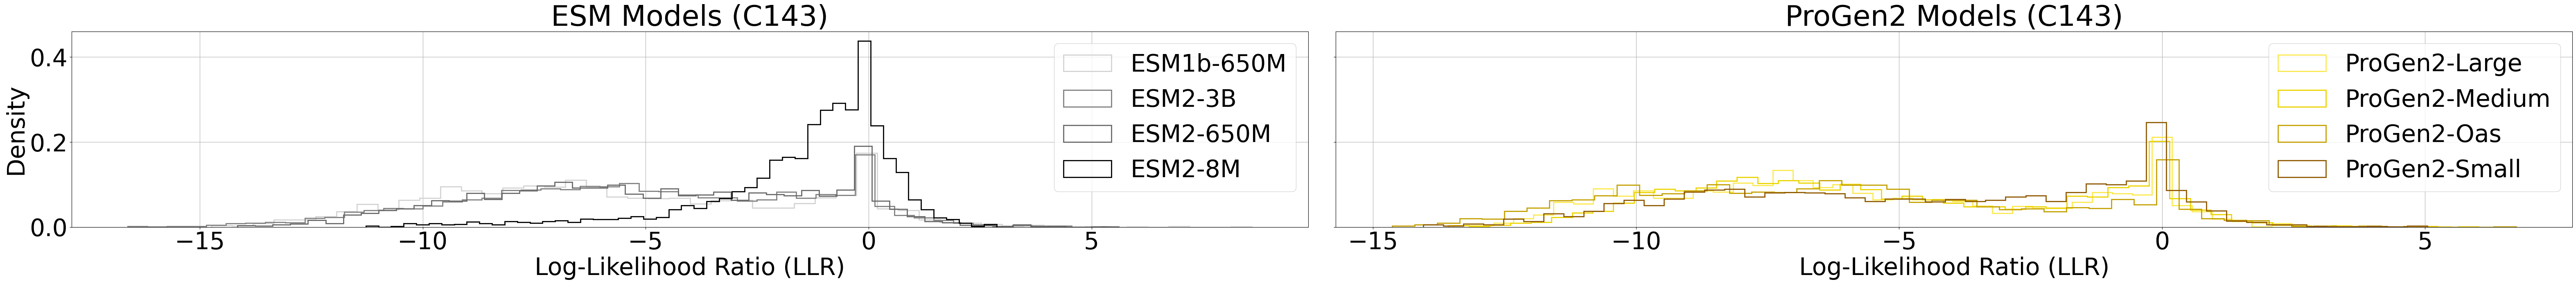

In [22]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

# — USER CONFIGURATION —————————————————————————————————————————————————————————
DATA_FOLDER = "ch2LLRdata"   # your folder of CSVs
ANTIBODY    = "C143"         # focus on this antibody
FONT_SIZE   = 42             # global font size

# — HELPERS ————————————————————————————————————————————————————————————————————————
def extract_esm_label(fname):
    """
    Given a filename like
      C143_facebook_esm2_t6_8M_UR50D_llr.csv
    returns "ESM2-8M"
    """
    parts = fname.replace(".csv", "").split("_")
    prefix = parts[2]  # 'esm2' or 'esm1b'
    # pick the part that is purely digits+letters (not t33, not UR50D)
    variant = next(p for p in parts if re.match(r"^\d+[A-Za-z]*$", p))
    prefix = prefix.replace("esm2", "ESM2").replace("esm1b", "ESM1b")
    return f"{prefix}-{variant}"

def extract_progen_label(fname):
    """
    Given a filename like
      C143_hugohrban_progen2-small_llr.csv
    returns "ProGen2-Small"
    """
    parts = fname.replace(".csv", "").split("_")
    tag   = parts[2]            # 'progen2-small'
    left, right = tag.split("-", 1)
    left  = left.replace("progen2", "ProGen2")
    right = right.capitalize()
    return f"{left}-{right}"

# — LOAD & MELT ALL C143 LLRs —————————————————————————————————————————————————————
esm_frames    = []
progen_frames = []

for fname in os.listdir(DATA_FOLDER):
    if not fname.endswith("_llr.csv"):
        continue
    if not fname.startswith(f"{ANTIBODY}_"):
        continue

    path = os.path.join(DATA_FOLDER, fname)
    df   = pd.read_csv(path)

    # drop any unnamed index columns
    drop = [c for c in df.columns if c.lower().startswith("unnamed")]
    df   = df.drop(columns=drop, errors="ignore")

    # melt wide → long
    df_long = df.melt(var_name="Position", value_name="LLR")

    if "facebook" in fname.lower():
        df_long["Model"] = extract_esm_label(fname)
        esm_frames.append(df_long)
    elif "hugohrban" in fname.lower():
        df_long["Model"] = extract_progen_label(fname)
        progen_frames.append(df_long)

# sanity check
if not esm_frames or not progen_frames:
    raise RuntimeError(f"Could not find both ESM & ProGen2 LLRs for {ANTIBODY}")

esm_df    = pd.concat(esm_frames,    ignore_index=True)
progen_df = pd.concat(progen_frames, ignore_index=True)

# — PLOTTING ——————————————————————————————————————————————————————————————————————
# apply global font and legend size
plt.rcParams.update({
    "font.size": FONT_SIZE,
    "legend.fontsize": FONT_SIZE
})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(64, 8), sharey=True)

# color palettes
esm_cols    = ["lightgray", "gray", "dimgray", "black"]
progen_cols = ["#fce94f", "#edd400", "#c4a000", "#8f5902"]

# — Left: ESM models —
for i, model in enumerate(sorted(esm_df["Model"].unique())):
    data = esm_df.loc[esm_df["Model"] == model, "LLR"]
    ax1.hist(
        data,
        bins=50,
        density=True,
        histtype="step",
        linewidth=2,
        label=model,
        color=esm_cols[i]
    )
ax1.set_title(f"ESM Models ({ANTIBODY})")
ax1.set_xlabel("Log-Likelihood Ratio (LLR)")
ax1.set_ylabel("Density")
ax1.grid(True)
ax1.legend(loc="upper right")

# — Right: ProGen2 models —
for i, model in enumerate(sorted(progen_df["Model"].unique())):
    data = progen_df.loc[progen_df["Model"] == model, "LLR"]
    ax2.hist(
        data,
        bins=50,
        density=True,
        histtype="step",
        linewidth=2,
        label=model,
        color=progen_cols[i]
    )
ax2.set_title(f"ProGen2 Models ({ANTIBODY})")
ax2.set_xlabel("Log-Likelihood Ratio (LLR)")
ax2.grid(True)
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()


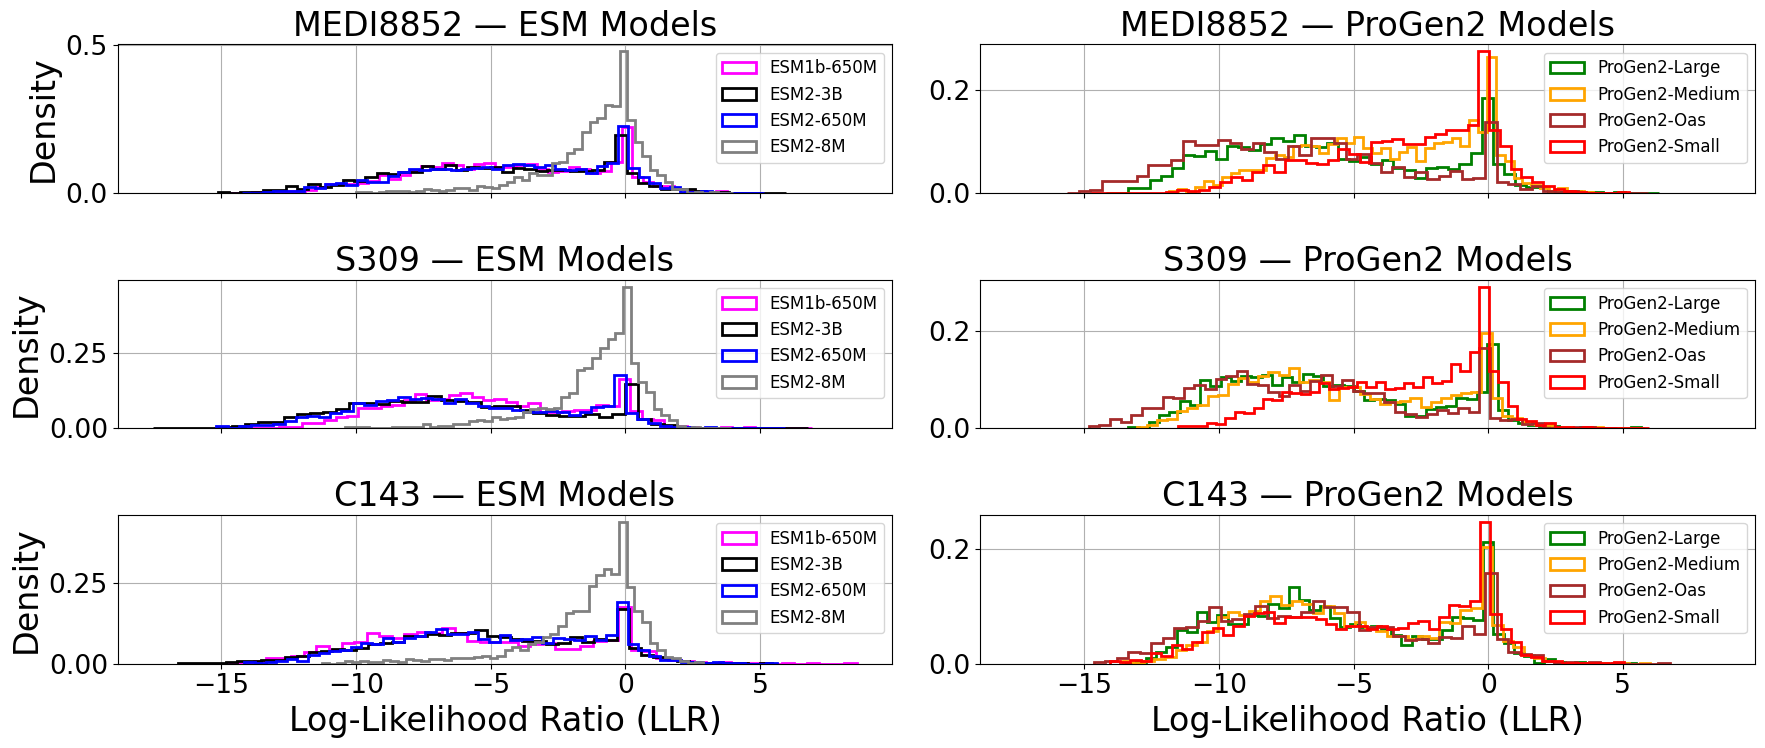

In [39]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

# — USER CONFIGURATION ———————————————————————————————————————————————————————
DATA_FOLDER       = "ch2LLRdata"       # folder containing your *_llr.csv files
ANTIBODIES        = ["MEDI8852", "S309", "C143"]
FONT_SIZE         = 24                 # font size for titles, labels, ticks
LEGEND_FONT_SIZE  = 12                 # separate font size for legend text
FIG_WIDTH         = 18
FIG_HEIGHT        = 8

# — SHARED COLOR PALETTES —————————————————————————————————————————————————————
ESM_COLORS    = ["magenta", "black", "blue", "grey"]  
PROGEN_COLORS = ["green", "orange", "brown", "red"]  

# — HELPERS —————————————————————————————————————————————————————————————————————
def extract_esm_label(fname):
    parts  = fname.replace(".csv", "").split("_")
    prefix = parts[2]  # 'esm2' or 'esm1b'
    variant = next(p for p in parts if re.match(r"^\d+[A-Za-z]*$", p))
    prefix = prefix.replace("esm2", "ESM2").replace("esm1b", "ESM1b")
    return f"{prefix}-{variant}"

def extract_progen_label(fname):
    parts = fname.replace(".csv", "").split("_")
    tag   = parts[2]  # 'progen2-small'
    left, right = tag.split("-", 1)
    left  = left.replace("progen2", "ProGen2")
    right = right.capitalize()
    return f"{left}-{right}"

def load_llr_for_antibody(ab, folder):
    esm_list, progen_list = [], []
    for fname in os.listdir(folder):
        if not fname.endswith("_llr.csv") or not fname.startswith(f"{ab}_"):
            continue
        df = pd.read_csv(os.path.join(folder, fname))
        # drop any unnamed index cols
        df = df.drop(columns=[c for c in df.columns if c.lower().startswith("unnamed")], errors="ignore")
        long = df.melt(var_name="Position", value_name="LLR")

        if "facebook" in fname.lower():
            long["Model"] = extract_esm_label(fname)
            esm_list.append(long)
        elif "hugohrban" in fname.lower():
            long["Model"] = extract_progen_label(fname)
            progen_list.append(long)

    if not esm_list or not progen_list:
        raise RuntimeError(f"Missing data for {ab}")
    return pd.concat(esm_list, ignore_index=True), pd.concat(progen_list, ignore_index=True)

# — SET GLOBAL FONT SIZES —————————————————————————————————————————————————————
plt.rcParams.update({
    "font.size":      FONT_SIZE,
    "axes.titlesize": FONT_SIZE,
    "axes.labelsize": FONT_SIZE,
    "xtick.labelsize": FONT_SIZE * 0.8,
    "ytick.labelsize": FONT_SIZE * 0.8,
})

# — MAKE PLOT GRID ——————————————————————————————————————————————————————————————
fig, axes = plt.subplots(len(ANTIBODIES), 2,
                         figsize=(FIG_WIDTH, FIG_HEIGHT),
                         sharex=True)

for row, ab in enumerate(ANTIBODIES):
    esm_df, progen_df = load_llr_for_antibody(ab, DATA_FOLDER)

    # — Left: ESM models —
    ax = axes[row, 0]
    for i, model in enumerate(sorted(esm_df["Model"].unique())):
        llrs = esm_df.loc[esm_df["Model"] == model, "LLR"]
        ax.hist(
            llrs, bins=50, density=True, histtype="step",
            linewidth=2, label=model, color=ESM_COLORS[i]
        )
    ax.set_title(f"{ab} — ESM Models")
    if row == len(ANTIBODIES) - 1:
        ax.set_xlabel("Log-Likelihood Ratio (LLR)")
    ax.set_ylabel("Density")
    ax.grid(True)
    ax.legend(loc="upper right", fontsize=LEGEND_FONT_SIZE)

    # — Right: ProGen2 models —
    ax = axes[row, 1]
    for i, model in enumerate(sorted(progen_df["Model"].unique())):
        llrs = progen_df.loc[progen_df["Model"] == model, "LLR"]
        ax.hist(
            llrs, bins=50, density=True, histtype="step",
            linewidth=2, label=model, color=PROGEN_COLORS[i]
        )
    ax.set_title(f"{ab} — ProGen2 Models")
    if row == len(ANTIBODIES) - 1:
        ax.set_xlabel("Log-Likelihood Ratio (LLR)")
    ax.grid(True)
    ax.legend(loc="upper right", fontsize=LEGEND_FONT_SIZE)

plt.tight_layout()
plt.savefig("antibodyDensityAll.png")
plt.show()


In [42]:
import numpy as np
import matplotlib.pyplot as plt

# ── 1) YOUR DATA HERE ───────────────────────────────────────────────────────────
# heatmaps must be a list of 16 2D arrays, all the same shape:
#   [ LLR_MEDI8852, LLR_S309, LLR_C143, LLR_…, P_MEDI8852, P_S309, … P_C143 ]
heatmaps = [
    llr_medi8852, llr_s309, llr_c143, llr_ab4,  # first 8 = LLR
    llr_ab5, llr_ab6, llr_ab7, llr_ab8,
    prob_medi8852, prob_s309, prob_c143, prob_ab4,  # next 8 = probabilities
    prob_ab5, prob_ab6, prob_ab7, prob_ab8
]
# ── 2) DEFINE YOUR AXES ─────────────────────────────────────────────────────────
# exactly the residues shown on your y-axis (top→bottom)
residues = ["Y","W","T","S","R","Q","P","N","M","L","I","K","H","G","F","E","D","C","A"]

# positions = 1,2,3,... up to number of columns in each heatmap
n_positions = heatmaps[0].shape[1]
positions   = np.arange(1, n_positions+1)

# ── 3) COLOR SCALES ─────────────────────────────────────────────────────────────
llr_vmin, llr_vmax   = -15, 5
prob_vmin, prob_vmax = 0, 1

# ── 4) MAKE GRID ────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(4, 4, figsize=(12, 12), sharex=False, sharey=False)

for idx, ax in enumerate(axes.flat):
    data = heatmaps[idx]

    # choose colormap & scale
    if idx < 8:
        cmap, vmin, vmax = "viridis", llr_vmin, llr_vmax
    else:
        cmap, vmin, vmax = "magma", prob_vmin, prob_vmax

    im = ax.imshow(
        data,
        aspect="auto",
        cmap=cmap,
        vmin=vmin, vmax=vmax
    )

    # X ticks every 10 positions
    xt = np.arange(0, n_positions, 10)
    ax.set_xticks(xt)
    ax.set_xticklabels(positions[xt], rotation=45, fontsize=8)

    # Y ticks = every residue
    yt = np.arange(len(residues))
    ax.set_yticks(yt)
    ax.set_yticklabels(residues, fontsize=8)

    # optional: turn off spines for a cleaner look
    for spine in ax.spines.values():
        spine.set_visible(False)

# ── 5) SHARED COLORBAR ──────────────────────────────────────────────────────────
cbar = fig.colorbar(
    im,
    ax=axes.ravel().tolist(),
    orientation="vertical",
    fraction=0.02,
    pad=0.02
)
cbar.set_label("LLR / Probability", fontsize=12)

# ── 6) GLOBAL AXIS LABELS ───────────────────────────────────────────────────────
fig.text(0.5, 0.04, "Position", ha="center", va="center", fontsize=14)
fig.text(0.06, 0.5, "Residue", ha="center", va="center",
         rotation="vertical", fontsize=14)

plt.tight_layout(rect=[0.07, 0.07, 1, 1])
plt.show()


NameError: name 'llr_medi8852' is not defined